# AST 

In [1]:
import os
import re
import nltk
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import scipy.stats as stats
from scipy.stats import shapiro
from collections import Counter
from bs4 import BeautifulSoup, Tag
from difflib import SequenceMatcher
from scipy.stats import mannwhitneyu
from matplotlib import pyplot as plt
from nltk.probability import FreqDist
from collections import defaultdict, deque
from statistics import mean, variance, median
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from nltk.collocations import BigramCollocationFinder
from Levenshtein import distance as levenshtein_distance
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
function_tokens = {}
annotated_path = "../codesummary_eyetracking/task/analysis/fully_annotated"
annotated_files = os.listdir(annotated_path)
for file in annotated_files:
    name = re.sub(".csv", "", file)
    annotated = pd.read_csv(f"{annotated_path}/{file}")
    tokens = annotated['word'].astype(str)+"."+annotated['occurrence'].astype(str)
    function_tokens[name] = list(tokens)

# with open("midprocessing/function_tokens.pkl", "wb") as f:
#     pickle.dump(function_tokens, f)

In [2]:
with open("midprocessing/function_tokens.pkl", "rb") as f:
    function_tokens = pickle.load(f)
with open("midprocessing/ASTs.pkl", "rb") as f:
    trees = pickle.load(f)
with open("midprocessing/to_toss.pkl", "rb") as f:
    to_toss = pickle.load(f)

#### functions & computation

In [6]:
pointless = {',': 0,   '(': 0,   ')': 0, '()': 0,  '{': 0,   '}': 0, ');': 0,
            '),': 0, '));': 0,  '];': 0,  '[': 0,  ']': 0,  '))': 0, '){': 0,
             ';': 0,  ');': 0, '});': 0, '};': 0, '((': 0, ')){': 0, ')[': 0,
         '))));': 0, ')))': 0,  ')(': 0,  '.': 0,   '[':0, }


def helper_for_comments(func_name, parent, node, ogtree):
    tokens = function_tokens[func_name] # list of tokens
    for t in tokens:
        ratio = SequenceMatcher(a=node, b=t).ratio()
        if ratio > 0.6 and t != node:
            try:
                k = ogtree[parent].index(node)
                ogtree[t] = ogtree[node]
                ogtree[parent][k] = t
            except:
                x = 5
            # idx = tokens.index(t)
            # function_tokens[func_name][idx] = node

def node_correction(func_name, parent, subtree, tree, ogtree):
    for node in subtree:
        if parent:
            new_node = node
            if re.search('null', node):
                new_node = re.sub('null', 'nan', node)
            elif re.search('true', node):
                new_node = re.sub('true', 'TRUE', node)
            elif re.search('false', node):
                new_node = re.sub('false', 'FALSE', node)
            if new_node != node and ogtree[parent][0] != new_node:
                k = ogtree[parent].index(node)
                ogtree[new_node] = ogtree[node]
                ogtree[parent][k] = new_node
                
        if re.search(r"\/\/", node):
            helper_for_comments(func_name, parent, node, ogtree)
        else:
            for child in tree[node]:
                node_correction(func_name, child, tree[child], tree, ogtree)

def tree_walk(root, tag, parent):
    global tree, occurrences, count

    if isinstance(tag, Tag):
        parent = f"{tag.name}.{count-1}"
        if parent not in tree:
            tree[parent] = []
        for child in tag.children:
            if child.name:
                tree[parent].append(f"{child.name}.{count}")
                count += 1
            tree_walk(root, child, parent)

    elif tag:
        tag = tag.strip()
        if tag and tag not in pointless:
            if tag not in occurrences:
                if re.search(r"\/\/", tag):
                    occurrences[tag] = 200
                elif re.search(r"\".+\s+.+\"", tag):
                    occurrences[tag] = 100
                else:
                    occurrences[tag] = 0
            else:
                occurrences[tag] += 1
            leaf = f"{tag}.{occurrences[tag]}"
            tree[parent].append(leaf)
            tree[leaf] = []
            


In [281]:
filepath = '../codesummary_eyetracking/task/analysis/xml_trees'
tree_files = os.listdir(filepath)
trees = {}
for trunk in tree_files:
    count = 1
    tree = {}
    occurrences = {}
    name = re.sub("_wrapped.xml", "", trunk)

    with open(f'{filepath}/{trunk}', 'r') as f:
        data = f.read()

    soup = BeautifulSoup(data, features="xml")
    soup = soup.find('function')

    tree_walk(root=soup, tag=soup, parent='root')
    trees[name] = tree
    
for key in trees.keys():
    ogtree = copy.deepcopy(trees[key])
    node_correction(key, None, trees[key], trees[key], ogtree)
    trees[key] = ogtree
    
# with open(f"midprocessing/ASTs.pkl", "wb") as f:
#     pickle.dump(trees, f)


# Scan Path in Gaze Files

#### functions

In [7]:
def init_variables(filepath, df):
    aoi_start = -1
    if re.search("reading", filepath):
        aoi_start = df.columns.get_loc('prewritten')
    elif re.search("writing", filepath):
        aoi_start = df.columns.get_loc('code')
    bb_start = df.columns.get_loc("geometry")
    return [bb_start, aoi_start]

# preprocess function to downsample and narrow down to just bounding boxes
def preprocess(fullpath, downsample):
    gazedf = pd.read_csv(fullpath)
    if downsample:
        gazedf = gazedf[::2] # downsample 
        gazedf = gazedf.reset_index(drop=True)
    
    # get just the rows where participant was looking at code
    codedf = gazedf[gazedf['code'] == 1]
    codedf = codedf.reset_index(drop=True)
    return codedf
    
# print function might give trouble
# filter out all gaze points that aren't in the code
# return
def calculate_scan_path(filepath, codedf):
    bb_start, aoi_start = init_variables(filepath, codedf)
    bbdf = codedf.iloc[:, bb_start+1:aoi_start]
    scan_path = []
    count = 0 # used for calculating regressions later on
    curr_token = ''
    for i, row in bbdf.iterrows():
        index = np.where(row == 1)[0]
        if len(index) > 0:
            token = bbdf.columns[index][0]
            if token != curr_token:
                scan_path.append(token)
                curr_token = token
            else:
                count += 1
    return scan_path, count

# another function that calculates scan paths and returns list of strings corresponding to code parts

In [9]:
participants = os.listdir("/home/zachkaras/code_summ_data")

In [10]:
rscan_paths = {}
wscan_paths = {}
scan_path_per_person = {}
reading_functions = set()
writing_functions = set()
non_regressions = {}

for person in participants:
    print(person)
    scan_path_per_person[person] = {}
    metadir = f"/home/zachkaras/code_summ_data/{person}/annotated_gaze"
    gaze_files = os.listdir(metadir)
    downsample = True if int(person) < 300 else False
    non_regressions[person] = {}
    for file in gaze_files:    
        name = file.split('_')[-1]
        name = re.sub(".csv", "", name)
        
        # if this person's data needs to be excluded for this file
        if name in to_toss.keys() and int(person) in to_toss[name]:
            continue
           
        fullpath = f"{metadir}/{file}"
        
        preprocessed = preprocess(fullpath, downsample)
        scan_path, count = calculate_scan_path(file, preprocessed)
        scan_path_per_person[person][name] = scan_path
        non_regressions[person][name] = count
        
        if re.search("writing", file):
            writing_functions.add(name)
            if name not in wscan_paths:
                wscan_paths[name] = [scan_path]
            else:
                wscan_paths[name].append(scan_path)
        elif re.search("reading", file):
            reading_functions.add(name)
            if name not in rscan_paths:
                rscan_paths[name] = [scan_path]
            else:
                rscan_paths[name].append(scan_path)
    
    # print(len(scan_path_per_person))
    # break
                
# with open("midprocessing/reading_scanpaths.pkl", "wb") as f:
#     pickle.dump(rscan_paths, f)

# with open("midprocessing/writing_scanpaths.pkl", "wb") as f:
#     pickle.dump(wscan_paths, f)

# with open("midprocessing/participant_scanpaths.pkl", "wb") as f:
#     pickle.dump(scan_path_per_person, f)

# with open("midprocessing/reading_functions.pkl", "wb") as f:
#     pickle.dump(reading_functions, f)

# with open("midprocessing/writing_functions.pkl", "wb") as f:
#     pickle.dump(writing_functions, f)


136
176
155
117
166
317
168
319
186
182
310
129
111
313
315
133
143
311
314
106
318
147
191
189
316
312
139


# Abstract Scan Paths: NLP

In [2]:
with open("midprocessing/reading_scanpaths.pkl", "rb") as f:
    rscan_paths = pickle.load(f)
with open("midprocessing/writing_scanpaths.pkl", "rb") as f:
    wscan_paths = pickle.load(f)
with open("midprocessing/participant_scanpaths.pkl", "rb") as f:
    participant_scanpaths = pickle.load(f)
with open("midprocessing/reading_functions.pkl", "rb") as f:
    reading_functions = pickle.load(f)
with open("midprocessing/writing_functions.pkl", "rb") as f:
    writing_functions = pickle.load(f)
# with open("midprocessing/abstract_code_parts.pkl", "rb") as f:
with open("midprocessing/abstract_code_parts_by_precedence.pkl", "rb") as f:    
    abstract_code_parts = pickle.load(f)

In [15]:

# Level 3
# permutes 2-3 lists of abstract tokens
# input: [['variable', 'this'], ['parameter', 'type']]

# output: [['variable', 'parameter'], ['variable', 'type'],
# ['this', 'parameter'],
# ['this', 'type]]
def permute(lst):
    lst1 = lst[0]
    lst2 = lst[1]
    tri = False
    if len(lst) == 3:
        lst3 = lst[2]
        tri = True
    new = []
    for t1 in lst1:
        for t2 in lst2:
            if tri:
                for t3 in lst3:
                    if len({t1, t2, t3}) == 3:
                        new.append((t1, t2, t3))
            else:
                if len(set({t1, t2})) == 2:
                    new.append((t1, t2))
    return new

# Level 2
# function that takes in a scan path dictionary from one function {function: [[scanpath1], [scanpath2], [scanpath3]]}
# returns all abstract bigrams and trigrams of that function

def filter_duplicates(array):
    if len(set(array)) == len(array):
        return array
    else:
        return -1

def calculate_tuples(func, scan_paths, n):
    code_parts = abstract_code_parts[func]
    ngrams = []  # first calculating ngrams of the raw code, then abstracting later
    for path in scan_paths:  # figuring out if we need to handle bigrams or trigrams
        if n == 2:
            ngrams.extend(list(nltk.bigrams(path)))
        elif n == 3:
            ngrams.extend(list(nltk.trigrams(path)))

    # replace each tuple with a list of its abstract code parts ([variable declaration])
    # input: ['variable_1', 'String']
    # output: [['variable', 'variable declaration'], ['parameter', 'type']]
    abstract_tuples = []
    for i, tupl in enumerate(ngrams):
        abstract_tuple = []
        for token in tupl:
            # print(len(tupl), tupl[0], tupl[1])
            temp = code_parts[token]
            try:
                abstract_tuple = abstract_tuple + temp
            except:
                meaningless = 0

        abstract_tuple = filter_duplicates(abstract_tuple)
        if abstract_tuple != -1:
            abstract_tuple = tuple(abstract_tuple)
            # with the abstracted, nested list, permute to get ngrams again
            # input: [['variable', 'variable_declaration'], ['parameter', 'type']]
            # output: ngrams
            # new_tuples = permute(abstract_tuple)
            # print(tuple(abstract_tuple))
            abstract_tuples.append(abstract_tuple)
            # print("tuples", abstract_tuples)

    return abstract_tuples


# Level 1
# takes in scan paths, formatted as:
# {'function1': [['scan','path', '1'], ['scan', 'path', '2']]}
# {'function2': [['scan','path', '1'], ['scan', 'path', '2']]}
# returns abstract bigrams and trigrams for each function
def calculate_ngrams(scan_paths):
    all_bigrams = []
    all_trigrams = []
    for func in scan_paths.keys():  # iterating through all the keys/functions in the dictionary
        bigrams = calculate_tuples(func, scan_paths[func], 2)
        trigrams = calculate_tuples(func, scan_paths[func], 3)
        all_bigrams.extend(bigrams)
        all_trigrams.extend(trigrams)

    return all_bigrams, all_trigrams

qwer = set()
def format_bigrams(grams):
    replacing = {
        'function call': 'Method Call',
        'loop': 'Loop Body',
        'conditional block': 'Conditional Body',
        'conditional statement': 'Conditional Statement',
        'parameter': 'Parameter',
        'variable': 'Variable',
        'variable declaration': 'Variable Declaration',
        'argument': 'Argument',
        'function declaration': 'Method Declaration'
    }
    
    label = ''
    for i, g in enumerate(grams):
        new_gram = replacing[g]
        # print(new_gram)
        label += f"{new_gram} \u2192 " if i < len(grams)-1 else new_gram
    return label
    # print(label)
            
    # input is a tuple
    # function declaration --> method declaration
    # loop --> loop body
    # function call --> method call
    # conditional block --> conditional body
    # externally defined variable or function --> external class
    # 


In [17]:
rbigrams, rtrigrams = calculate_ngrams(rscan_paths)
wbigrams, wtrigrams = calculate_ngrams(wscan_paths)

# with open("midprocessing/reading_bigrams.pkl", "wb") as f:
#     pickle.dump(rbigrams, f)
# with open("midprocessing/reading_trigrams.pkl", "wb") as f:
#     pickle.dump(rtrigrams, f)
# with open("midprocessing/writing_bigrams.pkl", "wb") as f:
#     pickle.dump(wbigrams, f)
# with open("midprocessing/writing_trigrams.pkl", "wb") as f:
#     pickle.dump(wtrigrams, f)


In [4]:
with open("midprocessing/reading_bigrams.pkl", "rb") as f:
    rbigrams = pickle.load(f)
with open("midprocessing/reading_trigrams.pkl", "rb") as f:
    rtrigrams = pickle.load(f)
with open("midprocessing/writing_bigrams.pkl", "rb") as f:
    wbigrams = pickle.load(f)
with open("midprocessing/writing_trigrams.pkl", "rb") as f:
    wtrigrams = pickle.load(f)


In [18]:
# making distribution plots
test = Counter(rbigrams)
print(test)
test = Counter(rtrigrams)
print(test)
test = Counter(wbigrams)
print(test)
test = Counter(wtrigrams)
print(test)

Counter({('function declaration', 'variable declaration'): 1585, ('variable declaration', 'function declaration'): 1530, ('conditional statement', 'loop'): 802, ('loop', 'conditional statement'): 765, ('conditional statement', 'function declaration'): 717, ('function declaration', 'conditional statement'): 714, ('function declaration', 'parameter'): 596, ('function declaration', 'function call'): 483, ('function call', 'function declaration'): 472, ('parameter', 'function declaration'): 443, ('parameter', 'variable declaration'): 441, ('conditional statement', 'conditional block'): 394, ('variable declaration', 'parameter'): 369, ('conditional block', 'conditional statement'): 337, ('function declaration', 'argument'): 323, ('argument', 'variable declaration'): 316, ('variable declaration', 'conditional statement'): 306, ('argument', 'function declaration'): 302, ('function call', 'variable declaration'): 302, ('variable declaration', 'function call'): 298, ('variable declaration', 'ar

In [30]:
most_common_rtrigrams

[(('variable declaration', 'function declaration', 'parameter'), 109),
 (('function declaration', 'parameter', 'variable declaration'), 90),
 (('parameter', 'function declaration', 'variable declaration'), 67),
 (('parameter', 'variable declaration', 'function declaration'), 65),
 (('function declaration', 'variable declaration', 'parameter'), 62),
 (('function declaration', 'variable declaration', 'conditional statement'),
  60),
 (('conditional statement', 'function declaration', 'parameter'), 59),
 (('function declaration', 'parameter', 'conditional statement'), 59),
 (('variable declaration', 'conditional statement', 'loop'), 58),
 (('function declaration', 'conditional statement', 'conditional block'), 57),
 (('function call', 'function declaration', 'argument'), 54),
 (('conditional block', 'conditional statement', 'function declaration'), 52)]

In [29]:
most_common_wtrigrams

[(('variable declaration', 'function declaration', 'parameter'), 171),
 (('function declaration', 'conditional statement', 'conditional block'), 146),
 (('parameter', 'function declaration', 'variable declaration'), 138),
 (('conditional statement', 'function declaration', 'parameter'), 137),
 (('function declaration', 'parameter', 'variable declaration'), 136),
 (('parameter', 'function declaration', 'conditional statement'), 133),
 (('conditional block', 'conditional statement', 'function declaration'), 131),
 (('parameter', 'variable declaration', 'function declaration'), 126),
 (('variable declaration', 'loop', 'conditional statement'), 119),
 (('function declaration', 'variable declaration', 'parameter'), 115),
 (('variable declaration', 'conditional statement', 'loop'), 110),
 (('function declaration', 'parameter', 'conditional statement'), 106)]

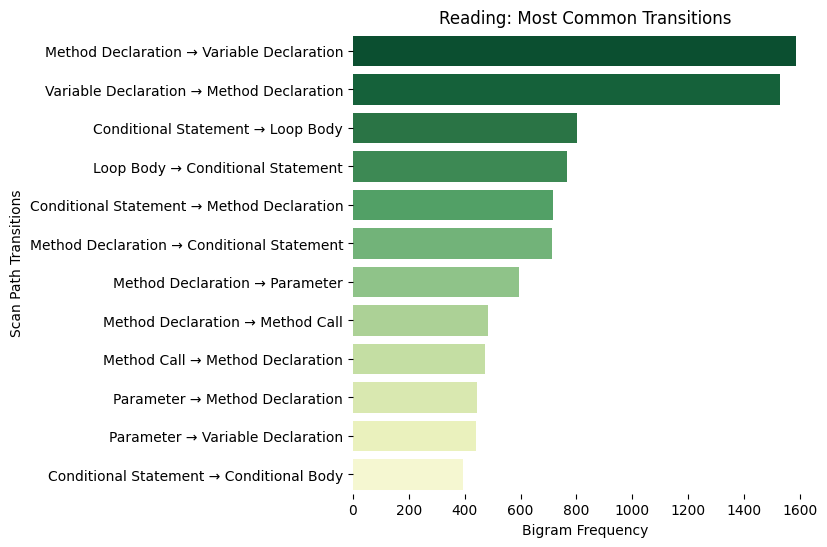

In [19]:
# try sorting dictionaries by values
# plotting
freq_distribution = FreqDist(rbigrams)
fig, ax = plt.subplots(figsize=(6, 6))
#sns.histplot(rbigrams, orientation='hortizontal')
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()

most_common_bigrams = freq_distribution.most_common(12)

# Unzip the bigrams and their frequencies into two separate lists
bigrams, freqs = zip(*most_common_bigrams)
bigrams = [format_bigrams(gram) for gram in bigrams]

# Create a color palette
# palette = sns.color_palette("coolwarm", len(bigrams))

# # Plot the bar chart
sns.barplot(x=list(freqs), y=list(bigrams), palette='YlGn_r', orient='h')
# This will rotate the x-axis labels so they fit better
ax.set_xlabel("Bigram Frequency")
ax.set_title("Reading: Most Common Transitions", fontsize=24)
# plt.xticks(rotation='vertical')
# plt.yticks(rotation='vertical')
plt.ylabel("Scan Path Transitions")
plt.title("Reading: Most Common Transitions")

sns.despine(left=True, bottom=True)
plt.savefig('plots/reading_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()



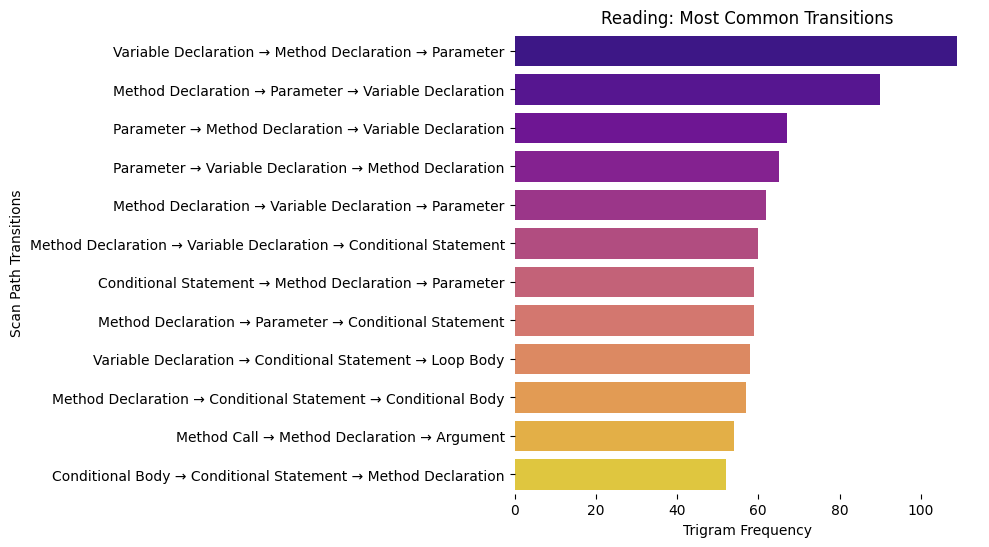

In [20]:
# freq_distribution = FreqDist(rtrigrams)
# plt.figure(figsize=(10, 5))
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()

rtfreq_distribution = FreqDist(rtrigrams)
fig, ax = plt.subplots(figsize=(6, 6))
#sns.histplot(rbigrams, orientation='hortizontal')
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()

most_common_rtrigrams = rtfreq_distribution.most_common(12)

# Unzip the bigrams and their frequencies into two separate lists
trigrams, freqs = zip(*most_common_rtrigrams)
trigrams = [format_bigrams(gram) for gram in trigrams]

# Create a color palette
# palette = sns.color_palette("coolwarm", len(bigrams))

# # Plot the bar chart
sns.barplot(x=list(freqs), y=list(trigrams), palette='plasma', orient='h')
# This will rotate the x-axis labels so they fit better
ax.set_xlabel("Trigram Frequency")
ax.set_title("Reading: Trigram Counts", fontsize=24)
# plt.xticks(rotation='vertical')
# plt.yticks(rotation='vertical')
plt.ylabel("Scan Path Transitions")
plt.title("Reading: Most Common Transitions")

sns.despine(left=True, bottom=True)
# plt.savefig('plots/gen_summ_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()



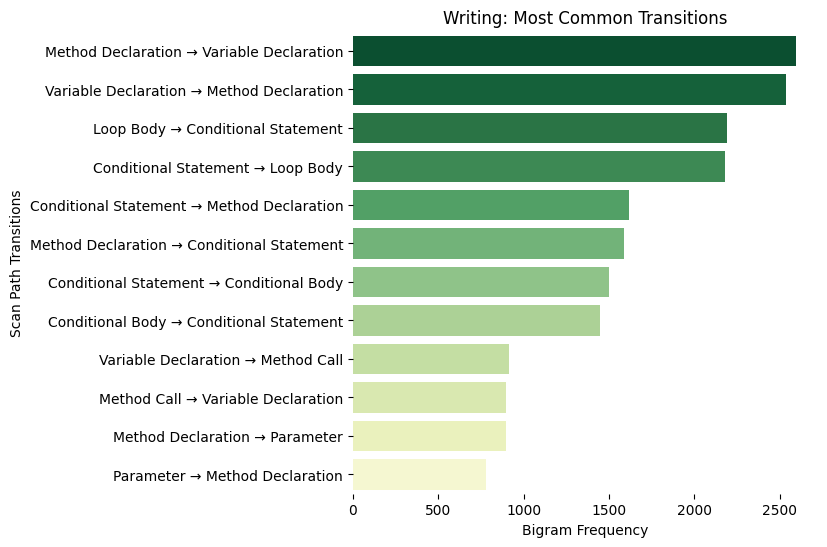

In [21]:
wfreq_distribution = FreqDist(wbigrams)
fig, ax = plt.subplots(figsize=(6, 6))
#sns.histplot(rbigrams, orientation='hortizontal')
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()

most_common_wbigrams = wfreq_distribution.most_common(12)

# Unzip the bigrams and their frequencies into two separate lists
bigrams, freqs = zip(*most_common_wbigrams)
bigrams = [format_bigrams(gram) for gram in bigrams]

# Create a color palette
# palette = sns.color_palette("coolwarm", len(bigrams))

# # Plot the bar chart
sns.barplot(x=list(freqs), y=list(bigrams), palette='YlGn_r', orient='h')
# This will rotate the x-axis labels so they fit better
ax.set_xlabel("Bigram Frequency")
ax.set_title("Writing: Most Common Transitions", fontsize=24)
# plt.xticks(rotation='vertical')
# plt.yticks(rotation='vertical')
plt.ylabel("Scan Path Transitions")
plt.title("Writing: Most Common Transitions")

sns.despine(left=True, bottom=True)
plt.savefig('plots/writing_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()
# freq_distribution = FreqDist(wbigrams)
# plt.figure(figsize=(10, 5))
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()


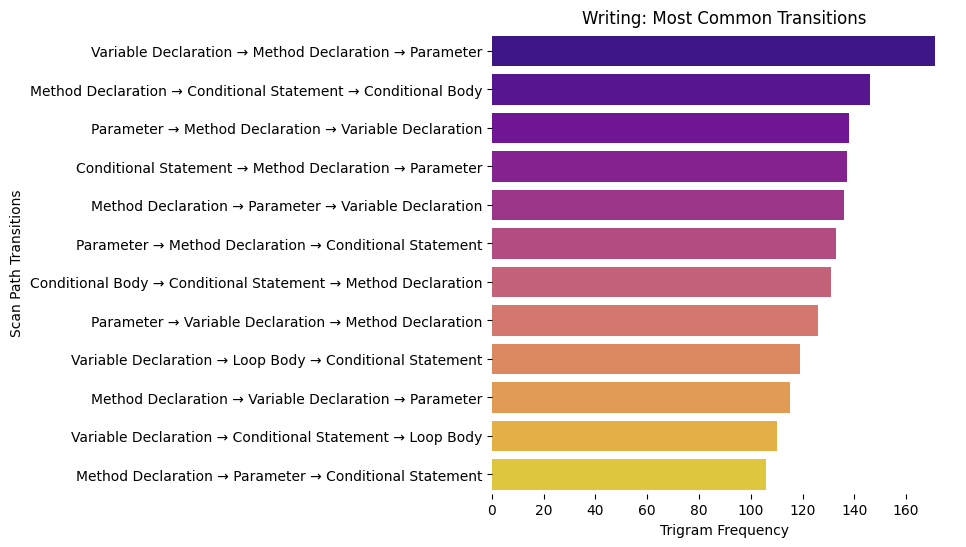

In [22]:
# freq_distribution = FreqDist(wtrigrams)
# plt.figure(figsize=(10, 5))
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()

wtfreq_distribution = FreqDist(wtrigrams)
fig, ax = plt.subplots(figsize=(6, 6))
#sns.histplot(rbigrams, orientation='hortizontal')
# freq_distribution.plot(30)  # Plotting the 30 most common bigrams
# plt.show()

most_common_wtrigrams = wtfreq_distribution.most_common(12)

# Unzip the bigrams and their frequencies into two separate lists
trigrams, freqs = zip(*most_common_wtrigrams)
trigrams = [format_bigrams(gram) for gram in trigrams]

# Create a color palette
# palette = sns.color_palette("coolwarm", len(bigrams))

# # Plot the bar chart
sns.barplot(x=list(freqs), y=list(trigrams), palette='plasma', orient='h')
# This will rotate the x-axis labels so they fit better
ax.set_xlabel("Trigram Frequency")
ax.set_title("Writing: Trigram Counts", fontsize=24)
# plt.xticks(rotation='vertical')
# plt.yticks(rotation='vertical')
plt.ylabel("Scan Path Transitions")
plt.title("Writing: Most Common Transitions")

sns.despine(left=True, bottom=True)
# plt.savefig('plots/gen_summ_bigrams.png', dpi=300, bbox_inches='tight')
plt.show()


# Calculating Distance

In [5]:
def normalize(lst, min_val, max_val):
    return [(x - min_val) / (max_val - min_val) for x in lst]

def cohens_d(list1, list2):
    n1, n2 = len(list1), len(list2)
    s1, s2 = np.var(list1, ddof=1), np.var(list2, ddof=1)
    pooled_var = ((n1-1) * s1 + (n2-1) * s2) / (n1 + n2 - 2)
    return (np.mean(list1) - np.mean(list2)) / np.sqrt(pooled_var)

def token_distance(tokens, t1, t2):
    index1 = tokens.index(t1)
    index2 = tokens.index(t2)
    regressive = False
    if index2 < index1:
        regressive = True        
    return abs(index1 - index2), regressive

# Convert tree to tree list
def tree_to_tree_list(tree):
    graph = defaultdict(list)
    for node in tree:
        for child in tree[node]:
            graph[node].append(child)
            graph[child].append(node)
    return graph                
    

# Find shortest path between nodes
def shortest_path(tree, start_node, end_node):
    graph = tree_to_tree_list(tree)
    queue = deque([[start_node]])
    visited = set()

    if start_node == end_node:
        return 0

    while queue:
        path = queue.popleft()
        node = path[-1]

        if node not in visited:
            neighbors = graph[node]

            for neighbor in neighbors:
                new_path = list(path)
                new_path.append(neighbor)
                queue.append(new_path)

                if re.search(r'\/\/', end_node):
                    end_node = end_node.split(".")[0]
                    neighbor = neighbor.split(".")[0]
                    ratio = SequenceMatcher(a=end_node, b=neighbor).ratio()
                    if ratio > 0.6:
                        end_node = neighbor
                if neighbor == end_node:
                    return len(new_path) - 1

            visited.add(node)

    return -1

def update_path(path):
    global longest_path_len, shortest_path_len
    pathlen = len(path)-1
    if pathlen > longest_path_len:
        longest_path_len = pathlen
    if pathlen < shortest_path_len:
        shortest_path_len = pathlen
        
def dfs(node, route, tree):
    global leaves, visited
    visited[node] = True
    route.append(node)
    if node in leaves:
        update_path(route)
    else:
        for child in tree[node]:
            if visited[child] == False:
                dfs(child, route, tree)
    route.pop()
    visited[node] = False

def get_leaves(tree):
    return[node for node, children in tree.items() if len(children) == 0]


# finding longest and shortest paths in tree
def tree_longest_and_shortest_path(tree):
    global longest_path_len, shortest_path_len, leaves, visited
    graph = tree_to_tree_list(tree)
    leaves = get_leaves(tree)
    longest_path_len = 0
    shortest_path_len = float('inf')
    visited = defaultdict(lambda: False)
    for leaf in leaves:
        try:
            next_node = graph[leaf][0]
        except:
            meaningless = 0
        visited[leaf] = True
        dfs(next_node, [leaf], graph)

    return shortest_path_len, longest_path_len

# FIXME/TODO - Least Common Ancestor


def calculate_average_distance(dict):
    global actual_long_path, actual_short_path
    all_token_distances = []
    all_tree_distances = []
    
    all_regressive = 0
    all_looks = 0
    for key in dict.keys():  # each function should be a key
        tree = trees[key]
        tokens = list(function_tokens[key])
        stim_min = 1
        stim_max = len(tokens)-1
        tree_min_path_len, tree_max_path_len = tree_longest_and_shortest_path(tree)
        
        for seq in dict[key]:  # each participant's scanpath for that function
            for i in range(len(seq)-1):  # calculating distance between each token
                token1, token2 = seq[i], seq[i+1]
                
                code_distance, regressive = token_distance(tokens, token1, token2)
                tree_distance = shortest_path(tree, token1, token2)
                if code_distance == -1 or tree_distance == -1:
                    continue
                elif regressive:
                    all_regressive += 1
                all_looks += 1
                code_distance = (code_distance - stim_min) / (stim_max - stim_min)
                tree_distance = (tree_distance - tree_min_path_len) / (tree_max_path_len - tree_min_path_len)
                
                all_token_distances.append(code_distance)
                all_tree_distances.append(tree_distance)

    return all_token_distances, all_tree_distances, (all_regressive/all_looks)

def calculate_average_distance_for_participants(dict):
    participant_token_distances = {}
    participant_tree_distances = {}
    
    all_regressive = 0
    all_looks = 0
    for key in dict.keys():  # each participant is a key
        for func in dict[key]:  # each participant's scanpath for that function
            all_token_distances = []
            all_tree_distances = []
            tree = trees[func]
            tokens = list(function_tokens[func])
            stim_min = 1
            stim_max = len(tokens)-1

            tree_min_path_len, tree_max_path_len = tree_longest_and_shortest_path(tree)
            for i in range(len(dict[key][func])-1):
                token1, token2 = dict[key][func][i], dict[key][func][i+1]
                code_distance, regressive = token_distance(tokens, token1, token2)
                tree_distance = shortest_path(tree, token1, token2)
                if code_distance == -1 or tree_distance == -1:
                    continue
                elif regressive:
                    all_regressive += 1
                all_looks += 1
                #all_looks += non_regressions[key][func]
                tree_distance = (tree_distance - tree_min_path_len) / (tree_max_path_len - tree_min_path_len)
                code_distance = (code_distance - stim_min) / (stim_max - stim_min)
                all_token_distances.append(code_distance)
                all_tree_distances.append(tree_distance)

            if key in participant_token_distances:
                participant_token_distances[key][func] = all_token_distances
                participant_tree_distances[key][func] = all_tree_distances
            else:
                participant_token_distances[key] = {func : all_token_distances}
                participant_tree_distances[key] = {func : all_tree_distances}


    return participant_token_distances, participant_tree_distances, (all_regressive/all_looks)


In [8]:
### TERMS
# rspd - reading scanpath distance
# wspd - writing scanpath distance
# pspd = participant scanpath distance
rspd_token, rspd_tree, rregress = calculate_average_distance(rscan_paths)
wspd_token, wspd_tree, wregress = calculate_average_distance(wscan_paths)
pspd_token, pspd_tree, pregress = calculate_average_distance_for_participants(participant_scanpaths)


rspd = {'token_distance': rspd_token, 'tree_distance': rspd_tree}
wspd = {'token_distance': wspd_token, 'tree_distance': wspd_tree}
spd = {'reading': rspd, 'writing': wspd}
pspd = {'token_distance': pspd_token, 'tree_distance': pspd_tree}
# with open('midprocessing/scanpath_distances_by_task.pkl', 'wb') as f:
#     pickle.dump(spd, f)
# with open('midprocessing/participant_scanpath_distances.pkl', "wb") as f:
#     pickle.dump(pspd, f)

In [11]:
len(rspd_token)

81692

In [27]:
print(wregress, rregress)

0.47169940105455355 0.45095770664609847


In [21]:
supreme_token_distances = copy.deepcopy(wspd_token)
supreme_tree_distances = copy.deepcopy(wspd_tree)
supreme_token_distances.extend(rspd_token)
supreme_tree_distances.extend(rspd_tree)

#### All token distances vs All tree distance 

In [37]:
distance_dictionary = {
    'comparison':[],
    'test':[],
    'group1 ave':[], # reading/token
    'group2 ave':[], # writing/tree
    'stat':[],
    'p val':[],
    'effect size':[]
    }

uncorrected_pvals = []

def add_to_dictionary(comparison, test, g1, g2, t, p, d):
    distance_dictionary['comparison'].append(comparison)
    distance_dictionary['test'].append(test)
    distance_dictionary['group1 ave'].append(g1)
    distance_dictionary['group2 ave'].append(g2)
    distance_dictionary['stat'].append(t)
    distance_dictionary['p val'].append(p)
    distance_dictionary['effect size'].append(d)

In [33]:
len(supreme_token_distances)

89719

In [34]:
len(supreme_tree_distances)

89719

In [38]:
stat, p = mannwhitneyu(supreme_token_distances, supreme_tree_distances, alternative='two-sided')
g1_ave = mean(supreme_token_distances)
g2_ave = mean(supreme_tree_distances)
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("mean of tree distances:", g2_ave)
print("mean of token distances", g1_ave)
d = cohens_d(supreme_token_distances, supreme_tree_distances)
print("Cohen's d: ", d)
add_to_dictionary('All Token vs. All Tree', 'Mann-U', g1_ave, g2_ave, stat, p, d)


Statistics=869986484.000, p=0.00000000000000000000
mean of tree distances: 0.4373119632083121
mean of token distances 0.12650387290361717
Cohen's d:  -1.7178883307650028


#### Writing Token Distances vs. Reading Token Distances

In [21]:
print(len(rspd_token)*2, len(wspd_token)*2)

56500 106884


In [40]:
print("reading normally distributed", shapiro(rspd_token))
print("writing normally distributed", shapiro(wspd_token))

rspd_ave = mean(rspd_token)
wspd_ave = mean(wspd_token)
print("reading average token distance", mean(rspd_token))
print("writing average token distance", mean(wspd_token))
d = cohens_d(rspd_token, wspd_token)
stat, p = mannwhitneyu(rspd_token, wspd_token, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d) # very small effect size
add_to_dictionary('Reading Token vs. Writing Token', 'Mann-U', rspd_ave, wspd_ave, stat, p, d)


/home/zachkaras/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


reading normally distributed ShapiroResult(statistic=0.7888458371162415, pvalue=0.0)
writing normally distributed ShapiroResult(statistic=0.8214551210403442, pvalue=0.0)
reading average token distance 0.11744413698100035
writing average token distance 0.13131425365149943
Statistics=839092048.500, p=0.00000000000000000000
Cohen's d:  -0.10397828866000854


#### Writing tree distances vs. Reading tree distances

In [41]:
print("reading normally distributed", shapiro(rspd_tree))
print("writing normally distributed", shapiro(wspd_tree))

rspd_ave = mean(rspd_tree)
wspd_ave = mean(wspd_tree)
print("reading average tree distance", mean(rspd_tree))
print("writing average tree distance", mean(wspd_tree))
d = cohens_d(rspd_tree, wspd_tree)
stat, p = mannwhitneyu(rspd_tree, wspd_tree, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)  # very small effect size
add_to_dictionary('Reading Tree vs. Writing Tree', 'Mann-U', rspd_ave, wspd_ave, stat, p, d)


reading normally distributed ShapiroResult(statistic=0.9825757145881653, pvalue=0.0)
writing normally distributed ShapiroResult(statistic=0.9845412969589233, pvalue=0.0)
reading average tree distance 0.43783694330159734
writing average tree distance 0.4370332184242113
Statistics=910543439.000, p=0.74473991969417641101
Cohen's d:  0.0036826950601083976


## Expertise Difference

In [12]:
def unpacking_helper(ddict, expert_list, novice_list, reading_functions):
    print(len(expert_list))
    print(len(novice_list))
    # Dictionary of lists
    result = {
        'rexp_tree': [], 'wexp_tree': [], 'rnov_tree': [], 'wnov_tree': [],
        'rexp_tok': [], 'wexp_tok': [], 'rnov_tok': [], 'wnov_tok': []
    }

    for distance_type, pid_dict in ddict.items():
        for pid, func_dict in pid_dict.items():
            exp = pid in expert_list
            nov = pid in novice_list
            if pid in expert_list:
                expertise = 'exp'
            elif pid in novice_list:
                expertise = 'nov'
            else:
                continue
            for func, scanpath in func_dict.items():
                # Determine category
                tok = distance_type == 'token_distance'
                reading = func in reading_functions

                # Create category string
                category = ('r' if reading else 'w') + expertise + ('_tok' if tok else '_tree')

                # Add to appropriate list
                result[category].extend(scanpath)

    return result   

def make_experience_terciles(df, criteria):
    if criteria == 'java':
        column = 'Java Experience'
    elif criteria == 'years':
        column = 'Years Coding'
    
    novice_i = np.where(df['Years Coding'] <= 4)[0]
    novices = df.loc[novice_i, 'ID']
    
    expert_i = np.where(df['Years Coding'] > 6)[0]
    experts = df.loc[expert_i, 'ID']
    # print(df.loc[novice_i, 'ID'])
    # print(novice_i)
    # df = df.sort_values(column).reset_index(drop=True)
    
    
    # split_here = len(df)//3
    # low = df.loc[:split_here-1, "ID"]
    # # med = df.loc[split_here:(2*split_here)]
    # high = df.loc[2*split_here:, "ID"]
    return [str(pid) for pid in novices], [str(pid) for pid in experts]
    

In [13]:
nd_demo = pd.read_csv("/storage1/code-summarization-study/NDStudy.csv")
vd_demo = pd.read_csv("/storage1/code-summarization-study/Task_Data_Vandy.csv")

In [14]:
all_demo = pd.concat([vd_demo, nd_demo])
all_demo = all_demo.reset_index()
all_demo = all_demo.drop(all_demo.index[[3, 4]]) # removing 119 and 122 from demographics data because 119 used the wrong task and didn't recalibrate, and the eye-tracker messed up for 122
all_demo = all_demo.reset_index()
women = ['111', '117', '129', '136', '166', '182', '317', '319']
# previously split experts and novices into two groups.
# Splitting into three to get more of a separation between the novices and the experts
ynov, yexp = make_experience_terciles(all_demo, 'years')
# jnov, jexp = make_experience_terciles(all_demo, 'java')
print(f"Coding Experts: {len(yexp)} | Coding Novices: {len(ynov)}")
print(list(yexp), list(ynov))


Coding Experts: 9 | Coding Novices: 10
['189', '310', '311', '312', '313', '315', '316', '318', '319'] ['111', '117', '129', '139', '147', '168', '176', '182', '186', '191']


In [15]:
expertise_by_years = unpacking_helper(pspd, yexp, ynov, reading_functions)
# expertise_by_java = unpacking_helper(pspd, jexp, reading_functions)

9
10


In [23]:
(len(expertise_by_years['rexp_tok']) + len(expertise_by_years['rnov_tok']))*2


42544

#### Experts vs. Novices (Based on years): Differences Distances for both tasks

In [23]:
# compare experts and novices by years, all token distances
# 'rexp_tree': [], 'wexp_tree': [], 'rnov_tree': [], 'wnov_tree': [],
# 'rexp_tok': [], 'wexp_tok': [], 'rnov_tok': [], 'wnov_tok': []
experts = expertise_by_years['rexp_tok'] + expertise_by_years['wexp_tok']
novices = expertise_by_years['rnov_tok'] + expertise_by_years['wnov_tok']
print("Token Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average token distance", mean(experts))
print("novice average token distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d) 

# compare experts and novices by years, all tree distances
experts = expertise_by_years['rexp_tree'] + expertise_by_years['wexp_tree']
novices = expertise_by_years['rnov_tree'] + expertise_by_years['wnov_tree']
print("\nTree Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average tree distance", mean(experts))
print("novice average tree distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)


Token Distance


ValueError: Data must be at least length 3.

#### Experts vs. Novices (Based on java experience): Differences in Distances for both tasks


In [49]:
# compare experts and novices by java experience, all token distances
experts = expertise_by_java['rexp_tok'] + expertise_by_java['wexp_tok']
novices = expertise_by_java['rnov_tok'] + expertise_by_java['wnov_tok']
print("Token Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average token distance", mean(experts))
print("novice average token distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)

# compare experts and novices by java experience, all tree distances
experts = expertise_by_java['rexp_tree'] + expertise_by_java['wexp_tree']
novices = expertise_by_java['rnov_tree'] + expertise_by_java['wnov_tree']
print("\nTree Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average tree distance", mean(experts))
print("novice average tree distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)


Token Distance
experts normally distributed ShapiroResult(statistic=0.8123038411140442, pvalue=0.0)
novices normally distributed ShapiroResult(statistic=0.811619758605957, pvalue=0.0)
expert average token distance 0.12429690547582276
novice average token distance 0.12766659576121814
Statistics=817527247.000, p=0.00000004777112375954
Cohen's d:  -0.025248948058240114

Tree Distance
experts normally distributed ShapiroResult(statistic=0.9830856323242188, pvalue=0.0)
novices normally distributed ShapiroResult(statistic=0.9850398898124695, pvalue=0.0)
expert average tree distance 0.4216718739615553
novice average tree distance 0.44438336414015067
Statistics=787808204.000, p=0.00000000000000000000
Cohen's d:  -0.10421417377600362


#### Experts vs. Novices (Based on years): Differences in Distances for Reading Task


In [60]:
# compare experts and novices on reading task by years, token distances
experts = expertise_by_years['rexp_tok']
novices = expertise_by_years['rnov_tok']
print("Token Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average token distance", mean(experts))
print("novice average token distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)

# compare experts and novices on reading task by years, tree distances
experts = expertise_by_years['rexp_tree']
novices = expertise_by_years['rnov_tree']
print("\nTree Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average tree distance", mean(experts))
print("novice average tree distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)


Token Distance
experts normally distributed ShapiroResult(statistic=0.7725865840911865, pvalue=0.0)
novices normally distributed ShapiroResult(statistic=0.7897744178771973, pvalue=0.0)
expert average token distance 0.11172707189814444
novice average token distance 0.11824219194806525
Statistics=55473559.500, p=0.00022994628492226200
Cohen's d:  -0.049765917047774236

Tree Distance
experts normally distributed ShapiroResult(statistic=0.9822073578834534, pvalue=1.276989294073415e-28)
novices normally distributed ShapiroResult(statistic=0.9820981025695801, pvalue=7.891132042152342e-41)
expert average tree distance 0.4357044690741478
novice average tree distance 0.439316710844478
Statistics=56630433.500, p=0.22095768749212285620
Cohen's d:  -0.016247812320184105


/home/zachkaras/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Experts vs. Novices (Based on java experience): Differences in Distances for Reading Task


In [51]:
# compare experts and novices on reading task by java experience, token distances
experts = expertise_by_java['rexp_tok']
novices = expertise_by_java['rnov_tok']
print("Token Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average token distance", mean(experts))
print("novice average token distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)

# compare experts and novices on reading task by java experience, tree distances
experts = expertise_by_java['rexp_tree']
novices = expertise_by_java['rnov_tree']
print("\nTree Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average tree distance", mean(experts))
print("novice average tree distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)


Token Distance
experts normally distributed ShapiroResult(statistic=0.7756489515304565, pvalue=0.0)
novices normally distributed ShapiroResult(statistic=0.7918099164962769, pvalue=0.0)
expert average token distance 0.1146758279176077
novice average token distance 0.11826209334164646
Statistics=100320576.000, p=0.00000419063121842970
Cohen's d:  -0.027273784199735383

Tree Distance
experts normally distributed ShapiroResult(statistic=0.980827808380127, pvalue=2.25503217943199e-33)
novices normally distributed ShapiroResult(statistic=0.9833981394767761, pvalue=2.2420775429197073e-44)
expert average tree distance 0.42127237394148664
novice average tree distance 0.44463460930061305
Statistics=97383673.500, p=0.00000000000000001231
Cohen's d:  -0.10501455508478125


#### Experts vs. Novices (Based on years): Differences in Distances for Writing Task


In [63]:
# compare experts and novices on writing task by years, token distances
experts = expertise_by_years['wexp_tok']
novices = expertise_by_years['wnov_tok']
print("Token Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average token distance", mean(experts))
print("novice average token distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)

# compare experts and novices on writing task by years, tree distances
experts = expertise_by_years['wexp_tree']
novices = expertise_by_years['wnov_tree']
print("\nTree Distance")
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average tree distance", mean(experts))
print("novice average tree distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)


Token Distance
experts normally distributed ShapiroResult(statistic=0.823794960975647, pvalue=0.0)
novices normally distributed ShapiroResult(statistic=0.819790244102478, pvalue=0.0)
expert average token distance 0.13174519297207607
novice average token distance 0.13150904951101638
Statistics=192818739.500, p=0.00136503652719033265
Cohen's d:  0.0017523926693788698

Tree Distance
experts normally distributed ShapiroResult(statistic=0.983713686466217, pvalue=1.0739957807140052e-39)
novices normally distributed ShapiroResult(statistic=0.9825775027275085, pvalue=4.203895392974451e-45)
expert average tree distance 0.45095274867947244
novice average tree distance 0.4236982026407793
Statistics=201802465.500, p=0.00000000000000000000
Cohen's d:  0.12584372354282697


/home/zachkaras/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


#### Experts vs. Novices (Based on java experience): Differences in Token Distances for Writing Task


In [53]:
# compare experts and novices on writing task by java experience, token distances
experts = expertise_by_java['wexp_tok']
novices = expertise_by_java['wnov_tok']
print('Token Distance')
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average token distance", mean(experts))
print("novice average token distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)

# compare experts and novices on writing task by java experience, tree distances
experts = expertise_by_java['wexp_tree']
novices = expertise_by_java['wnov_tree']
print('\nTree Distance')
print("experts normally distributed", shapiro(experts))
print("novices normally distributed", shapiro(novices))
print("expert average tree distance", mean(experts))
print("novice average tree distance", mean(novices))
d = cohens_d(experts, novices)
stat, p = mannwhitneyu(experts, novices, alternative='two-sided')
print('Statistics=%.3f, p=%.20f' % (stat, p))
print("Cohen's d: ", d)


Token Distance
experts normally distributed ShapiroResult(statistic=0.8295696377754211, pvalue=0.0)
novices normally distributed ShapiroResult(statistic=0.8206344842910767, pvalue=0.0)
expert average token distance 0.12958452723709082
novice average token distance 0.13271823505427968
Statistics=345486323.500, p=0.00156050552507800409
Cohen's d:  -0.023344988496796247

Tree Distance
experts normally distributed ShapiroResult(statistic=0.9834164381027222, pvalue=7.974060885271085e-40)
novices normally distributed ShapiroResult(statistic=0.984995424747467, pvalue=0.0)
expert average tree distance 0.4218914340874311
novice average tree distance 0.4442484075131906
Statistics=331226095.500, p=0.00000000000000000000
Cohen's d:  -0.1037724076313452


In [ ]:
# reading/writing bigrams by token/tree distance (rbi_tok, wbi_tok, rbi_tree, wbi_tree)
# reading/writing trigrams by token/tree distance (rtri_tok, wtri_tok, rtri_tree, wtri_tree)

# Read through raw bigrams 
# for each bigram, calculate the distance between them
# 

# Read through raw trigrams
# for each trigram, calculate the distance between them

In [12]:
# java_nd = list(nd_demo['Java Experience'])
# years_nd = list(nd_demo['Years Coding'])
# java = list(vd_demo['Java Experience'])
# years = list(vd_demo['Years Coding'])
# years.extend(years_nd)
# java.extend(java_nd)

# years_exp, years_nov = make_terciles(years)
# java_exp, java_nov = make_terciles(java)

# print(years_exp, years_nov)
# print(java_exp, java_nov)


# print(shapiro(java))
# print(shapiro(years))

# java_mdn = median(java)
# years_mdn = median(years)


# yexpert_nd = nd_demo[nd_demo['Years Coding'] >= years_mdn]
# jexpert_nd = nd_demo[nd_demo['Java Experience'] >= java_mdn]
# ynov_nd = nd_demo[nd_demo['Years Coding'] < years_mdn]
# jnov_nd = nd_demo[nd_demo['Java Experience'] < java_mdn]
# yexpert_nd = list(yexpert_nd['ID'])
# jexpert_nd = list(jexpert_nd['ID'])
# ynov_nd = list(ynov_nd['ID'])
# jnov_nd = list(jnov_nd['ID'])

# yexpert_vd = vd_demo[vd_demo['Years Coding'] >= years_mdn]
# jexpert_vd = vd_demo[vd_demo['Java Experience'] >= java_mdn]
# ynov_vd = vd_demo[vd_demo['Years Coding'] < years_mdn]
# jnov_vd = vd_demo[vd_demo['Java Experience'] < java_mdn]
# yexp = list(yexpert_vd['ID'])
# jexp = list(jexpert_vd['ID'])
# ynov = list(ynov_vd['ID'])
# jnov = list(jnov_vd['ID'])

# yexp.extend(yexpert_nd)
# jexp.extend(jexpert_nd)
# yexp = [str(id) for id in yexp]
# jexp = [str(id) for id in jexp]
# ynov.extend(ynov_nd)
# jnov.extend(jnov_nd)


[1, 2, 2, 3, 4, 4, 4, 4, 4] [6, 6, 7, 8, 8, 9, 10, 10, 11, 13, 14]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1, 1, 1] [3.0, 3, 3, 3, 4.0, 4.0, 4.0, 4, 5.0, 5, 5]
